In [9]:
# General
import numpy as np
import pandas as pd
import os

# For loading data and feature engineering
from feature_set_v2 import MergedDataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from sklearn.preprocessing import StandardScaler

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt

# Portfolio allocation
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier


In [10]:
# import importlib
# import feature_25 
# importlib.reload(feature_25)


In [17]:
# ============ 1) The Cross-Validation Function ============

def rolling_time_series_cv_sjm_long_short(
    lam,
    kappa,
    X,
    factor_returns,
    market_returns,
    n_splits=5,
    initial_train_size=8*252,
    val_size=1*252,
    cost_per_100pct=0.0005,
    annual_threshold=0.05
):
    """
    Rolling expanding-window CV function. For each fold, it clips/scales,
    fits a SparseJumpModel, does day-lag logic, and returns a single Sharpe.
    We then average across folds.
    """
    n_samples = len(X)  
    max_folds = (n_samples - initial_train_size) // val_size
    actual_folds = min(n_splits, max_folds)

    max_feats = int(kappa**2)
    sharpe_scores = []

    def position_from_expected_return(ann_ret, threshold=annual_threshold):
        if ann_ret > threshold: 
            return 1.0
        elif ann_ret < -threshold: 
            return -1.0
        else: 
            return ann_ret / threshold

    start_of_val = initial_train_size

    for fold_i in range(actual_folds):
        train_end = start_of_val
        val_end = start_of_val + val_size
        if val_end > n_samples:
            val_end = n_samples

        # 1) Raw slices
        X_train_cv_raw = X.iloc[:train_end]
        y_train_cv     = factor_returns.iloc[:train_end]
        m_train_cv     = market_returns.iloc[:train_end]

        X_val_cv_raw   = X.iloc[train_end:val_end]
        y_val_cv       = factor_returns.iloc[train_end:val_end]
        m_val_cv       = market_returns.iloc[train_end:val_end]

        # 2) Clipper/scaler on training portion only - fit_transform on train, transform on val
        clipper_fold = DataClipperStd(mul=3.)
        X_train_cv_raw_clipped = clipper_fold.fit_transform(X_train_cv_raw) 
        X_val_cv_raw_clipped   = clipper_fold.transform(X_val_cv_raw)

        scaler_fold = StandardScaler()
        X_train_cv = scaler_fold.fit_transform(X_train_cv_raw_clipped)
        X_val_cv   = scaler_fold.transform(X_val_cv_raw_clipped)

        # 3) Calculate active return on training set and fit SJM
        active_train_cv = y_train_cv - m_train_cv
        model = SparseJumpModel(
            n_components=2,
            max_feats=max_feats,
            jump_penalty=lam,
            cont=False,
            max_iter=30
        )
        model.fit(X_train_cv, ret_ser=active_train_cv, sort_by="cumret")

        # 4) Regime inference on validation
        val_states = model.predict_online(X_val_cv)
        train_states = model.predict(X_train_cv) # historical state classification to be used in the market return by state

        # 5) Evaluate strategy: day-lag logic
        val_active_ret = y_val_cv - m_val_cv
        strategy_ret = np.zeros(len(val_states)) # Intialize strategy returns to 0 for all days
        prev_position = 0.0

        # # Compute expected return per regime from training
        # state_avg_daily_ret = model.ret_
        # #state_avg_mkt_ret = m_train_cv.mean() # old method, not per state
        # state_avg_mkt_ret = {
        #     st: m_train_cv[train_states == st].mean()  # Filter market returns for days in state st.
        #     for st in range(len(state_avg_daily_ret))
        # }

        # # Compute expected active return per regime from training
        # state_to_expected = {
        #     st: (state_avg_daily_ret[st] - state_avg_mkt_ret[st])*252
        #     for st in range(len(state_avg_daily_ret))
        # }

        # NEW: Compute expected active return per regime from training (already active returns now)
        state_avg_daily_active_ret = model.ret_
        state_to_expected = {
            st: state_avg_daily_active_ret[st] * 252  # annualize daily active returns
            for st in range(len(state_avg_daily_active_ret))
        }


        for t in range(len(val_states)):
            daily_pnl = prev_position * val_active_ret.iloc[t]
            st = val_states[t]
            new_position = position_from_expected_return(state_to_expected.get(st,0.0)) # fetches the expected active return for the current state stst from the state_to_expected dictionary
            turnover = abs(new_position - prev_position)*2.0
            cost = turnover * cost_per_100pct
            strategy_ret[t] = daily_pnl - cost
            prev_position = new_position

        avg_ret = np.mean(strategy_ret)
        std_ret = np.std(strategy_ret, ddof=1)
        val_sharpe = 0.0 if std_ret==0 else (avg_ret/std_ret)*np.sqrt(252)

        sharpe_scores.append(val_sharpe)
        start_of_val += start_of_val  # expand window for next fold by 6 months

    return np.mean(sharpe_scores)

In [18]:
###############################################################################
# 1) HELPER: EWMA Covariance
###############################################################################
def ewm_covariance(returns: pd.DataFrame, halflife=126, min_periods=1) -> pd.DataFrame:
    """
    Compute an exponentially weighted covariance matrix over all data in 'returns'.
    The half-life is 126 days, meaning weights decay by 50% every 126 days.
    We then select the final NxN slice from the multi-index result.
    """
    ewm_cov = returns.ewm(halflife=halflife, adjust=False, min_periods=min_periods).cov()
    if len(returns) == 0:
        # Return an empty DataFrame if no data
        return pd.DataFrame()
    last_date = returns.index[-1]
    df_slice = ewm_cov.loc[last_date]  # shape (N, N)
    df_slice.index.name = None
    return df_slice

In [19]:
###############################################################################
# 2) HELPER: Rolling + Expanding Black–Litterman
###############################################################################
def run_bl_portfolio_pyopt_expanding(
    factor_dict,
    returns_df,
    test_index,
    tau=0.05,
    delta=2.5
):
    """
    An expanding-window Black–Litterman procedure:
    - For each date t in test_index, we take all historical data up to t-1 to compute:
       (a) an EWMA covariance (with half-life=126)
       (b) a BL prior using pi="equal"  (i.e. all assets get equal baseline expected return)
       (c) factor-based relative views: factor vs Market => P, Q
    - Then we get posterior (bl_returns, bl_cov).
    - Then run a standard Efficient Frontier (max_sharpe).
    - We store the resulting weights for day t+1 (one-day lag).
    """
    assets = list(returns_df.columns)   # e.g. [factor1, factor2, ..., Market]
    factors = list(factor_dict.keys())  # e.g. [factor1, factor2, ...]
    weights_df = pd.DataFrame(index=test_index, columns=assets, dtype=float)

    test_dates = list(test_index)

    for i, t in enumerate(test_dates):
        # 1) Expand up to day t-1
        window_end_idx = returns_df.index.get_loc(t)
        if window_end_idx == 0:
            # No prior data => skip
            continue
        expanding_slice = returns_df.iloc[:window_end_idx]

        # 2) Compute the EWMA covariance
        cov_matrix = ewm_covariance(expanding_slice, halflife=126, min_periods=60)
        if cov_matrix.empty or cov_matrix.isna().any().any():
            # If invalid, skip
            continue

        # 3) Construct the (P, Q) for factor vs Market
        #    Q is the list of "annual active returns" for each factor's bull/bear regime
        P_matrix = []
        Q_values = []
        for fac in factors:
            # Which regime do we see for factor "fac" at day t?
            st = factor_dict[fac]['states'].loc[t]
            daily_active_ret = factor_dict[fac]['regime_returns'][st]  # daily factor active
            annual_active_ret = daily_active_ret * 252
            Q_values.append(annual_active_ret)

            # row is +1 on factor, -1 on 'Market'
            row = [0]*len(assets)
            row[assets.index(fac)] = 1
            row[assets.index("Market")] = -1
            P_matrix.append(row)

        P = pd.DataFrame(P_matrix, columns=assets)
        Q = pd.Series(Q_values)

        # 4) Build the Black–Litterman model
        #    We'll say pi="equal" so that each asset has the same baseline prior
        #    Then we incorporate the relative views in (P, Q).
        #    tau=0.05 is a typical default.
        try:
            bl = BlackLittermanModel(
                cov_matrix=cov_matrix,
                pi="equal",
                P=P,
                Q=Q,
                tau=tau,
                delta=delta,
                # no "omega" => default is Proportional to var of view portfolio
            )
        except Exception as e:
            print(f"BL Model error on day {t}: {e}")
            continue

        # 5) Retrieve posterior returns & covariance
        mu_bl = bl.bl_returns()
        cov_bl = bl.bl_cov()  # posterior covariance

        # 6) Mean-variance optimization
        ef = EfficientFrontier(mu_bl, cov_bl, weight_bounds=(-0, 1))
        try:
            ef.max_sharpe()  # or ef.min_volatility() etc.
        except Exception as e:
            print(f"Optimization error on day {t}: {e}")
            continue

        # 7) Store weights for day t+1 (one-day lag)
        w_series = pd.Series(ef.clean_weights(), name=t)
        if i < len(test_dates) - 1:
            rebalance_day = test_dates[i+1]
            weights_df.loc[rebalance_day] = w_series
        else:
            weights_df.loc[t] = w_series

    return weights_df


In [20]:
# ---------------------------------------------------------------------
# Sharpe Ratio
# ---------------------------------------------------------------------
def annualized_sharpe(r):
    return (r.mean() / r.std()) * np.sqrt(252)

In [21]:
# # manual build of best_hyperparams dict for BL model if we don't want to run the SJM CV again
# best_hyperparams = {
#     "IWF": {
#         "best_lambda": 66.17434558908558,
#         "best_kappa": 2.0
#     },
#     "MTUM": {
#         "best_lambda": 239.5026619987486,
#         "best_kappa": 2.0
#     },
#     "QUAL": {
#         "best_lambda": 66.17434558908558,
#         "best_kappa": 2.44948974278
#     },
#     "SIZE": {
#         "best_lambda": 49.72235891449993,
#         "best_kappa": 3.46410161514
#     },
#     "USMV": {
#         "best_lambda": 751.3842180360134,
#         "best_kappa": 2.44948974278
#     },
#     "VLUE": {
#         "best_lambda": 57.36152510448679,
#         "best_kappa": 2
#     },
# }



Loading data for factor iwf

Loading data for factor mtum

Loading data for factor qual

Loading data for factor size

Loading data for factor usmv

Loading data for factor vlue

INITIAL CROSS-VALIDATION (BEFORE TEST PERIOD)

Running initial SJM cross-validation for factor = iwf
Training window: 2009-01-05 00:00:00 to 2016-12-30 00:00:00 (7.98 years)
[iwf] Best Jump Penalty (λ): 30.0
[iwf] Best Max Features (κ²): 4
[iwf] Sharpe with best hyperparams: nan


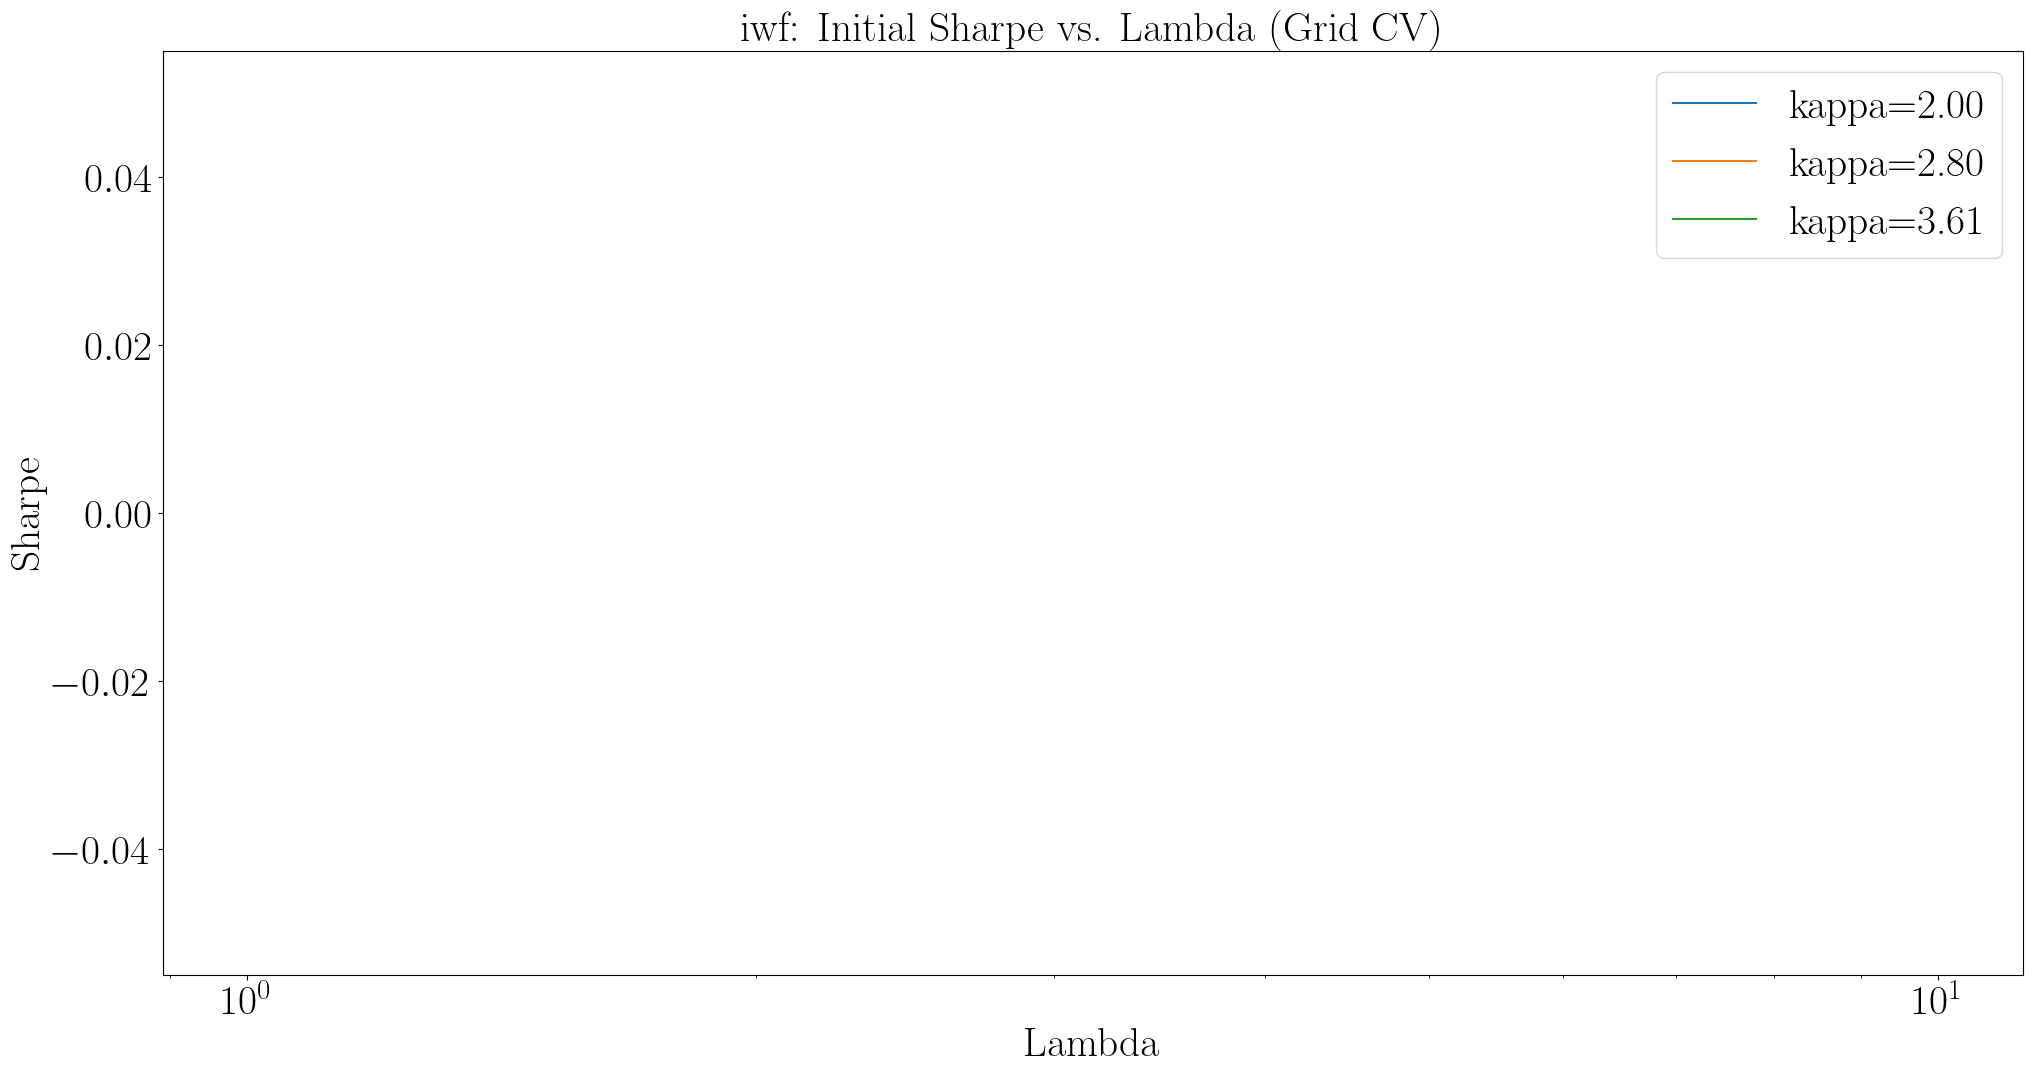


Running initial SJM cross-validation for factor = mtum
Training window: 2009-01-05 00:00:00 to 2016-12-30 00:00:00 (7.98 years)
[mtum] Best Jump Penalty (λ): 30.0
[mtum] Best Max Features (κ²): 4
[mtum] Sharpe with best hyperparams: nan


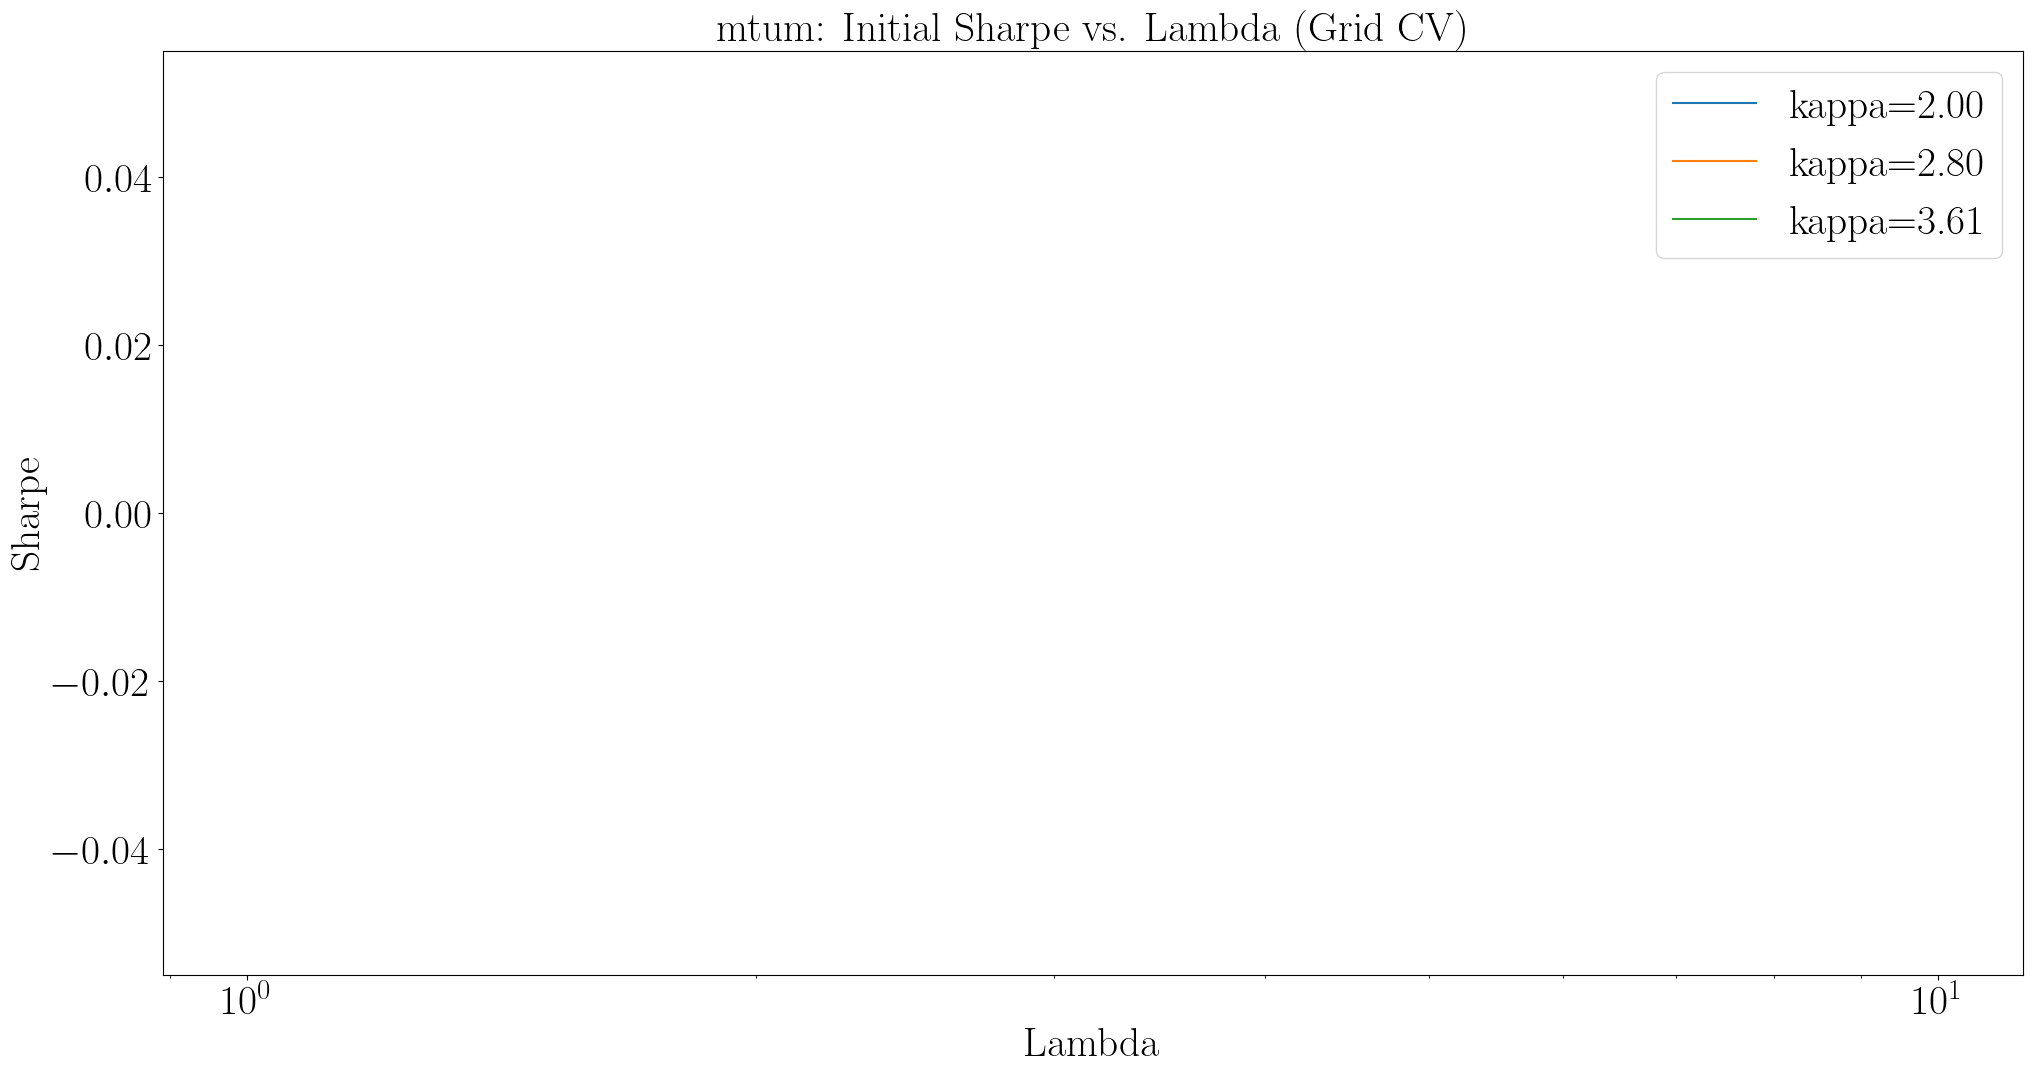


Running initial SJM cross-validation for factor = qual
Training window: 2009-01-05 00:00:00 to 2016-12-30 00:00:00 (7.98 years)
[qual] Best Jump Penalty (λ): 30.0
[qual] Best Max Features (κ²): 4
[qual] Sharpe with best hyperparams: nan


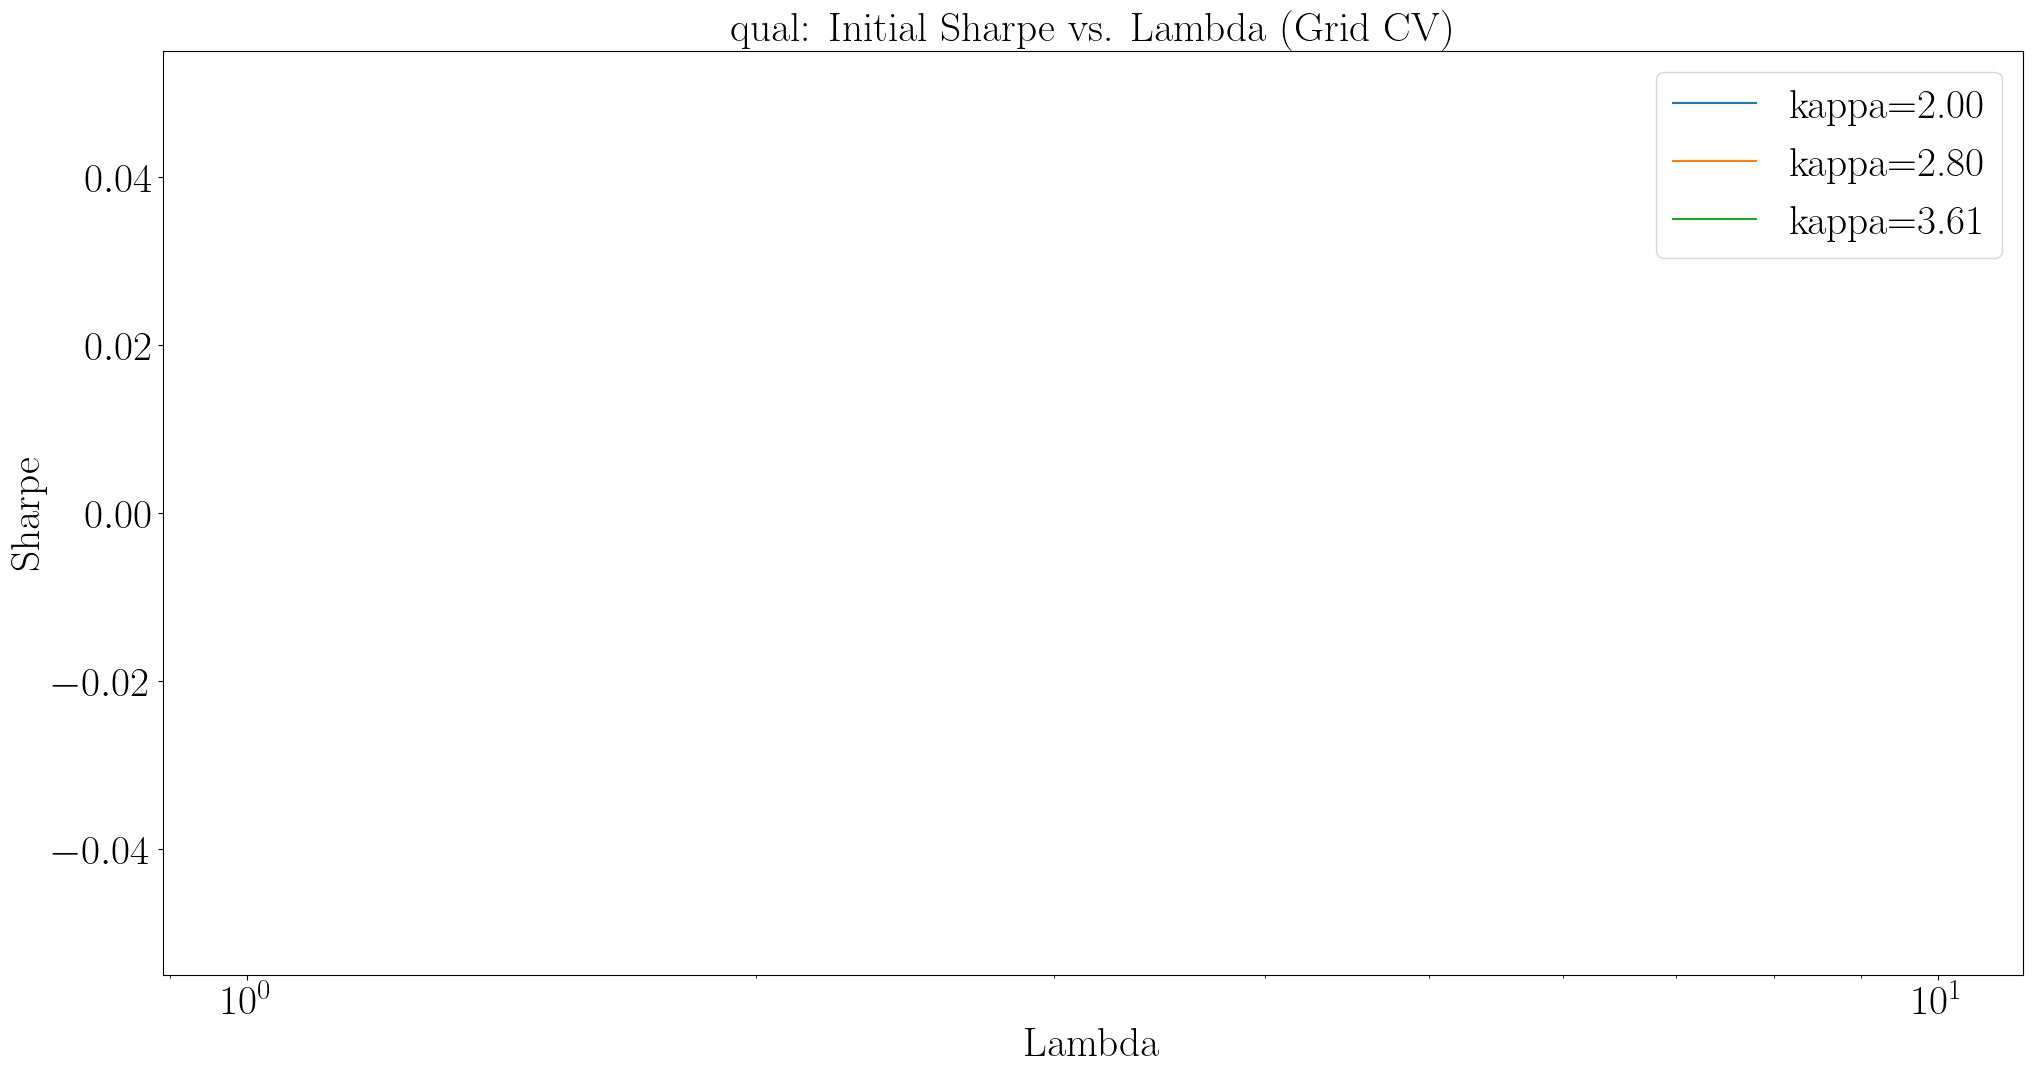


Running initial SJM cross-validation for factor = size
Training window: 2009-01-05 00:00:00 to 2016-12-30 00:00:00 (7.98 years)
[size] Best Jump Penalty (λ): 30.0
[size] Best Max Features (κ²): 4
[size] Sharpe with best hyperparams: nan


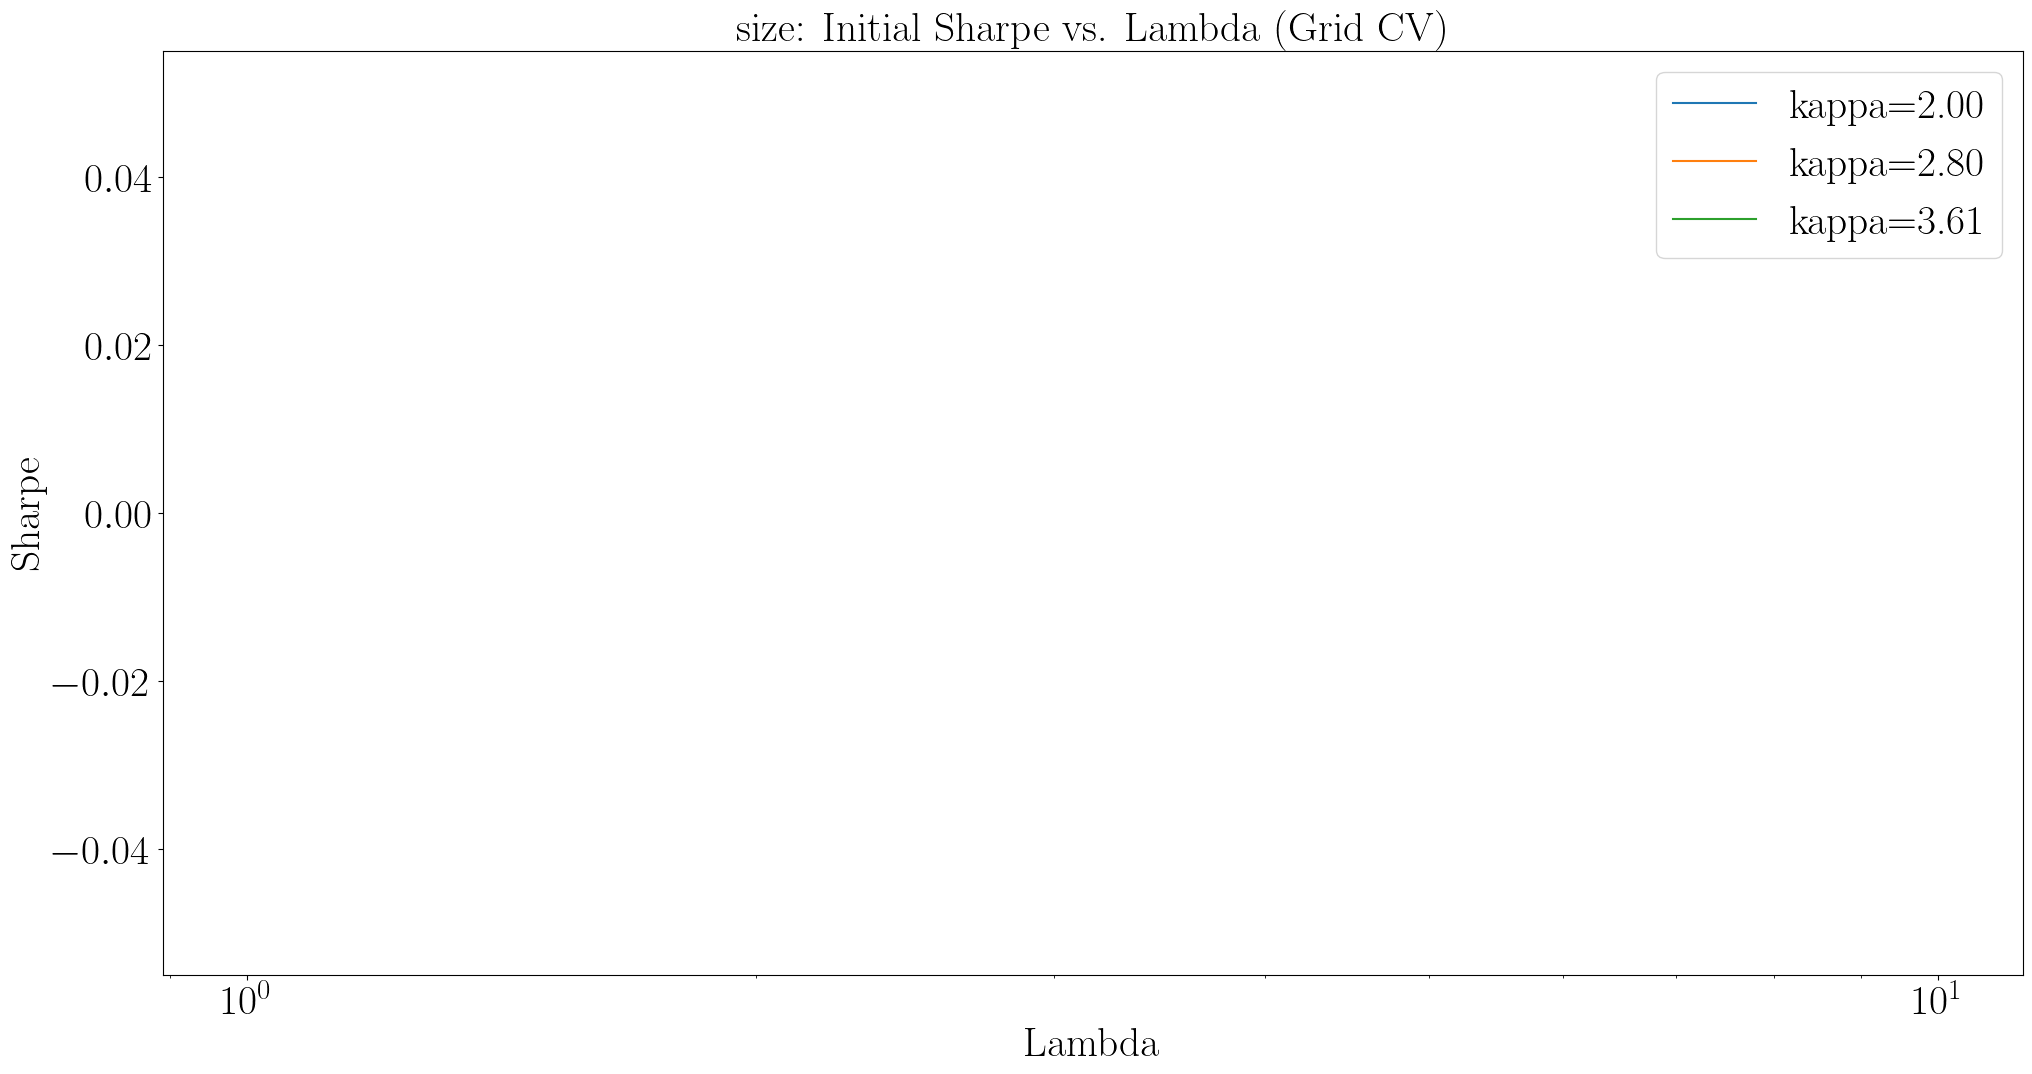


Running initial SJM cross-validation for factor = usmv
Training window: 2009-01-05 00:00:00 to 2016-12-30 00:00:00 (7.98 years)
[usmv] Best Jump Penalty (λ): 30.0
[usmv] Best Max Features (κ²): 4
[usmv] Sharpe with best hyperparams: nan


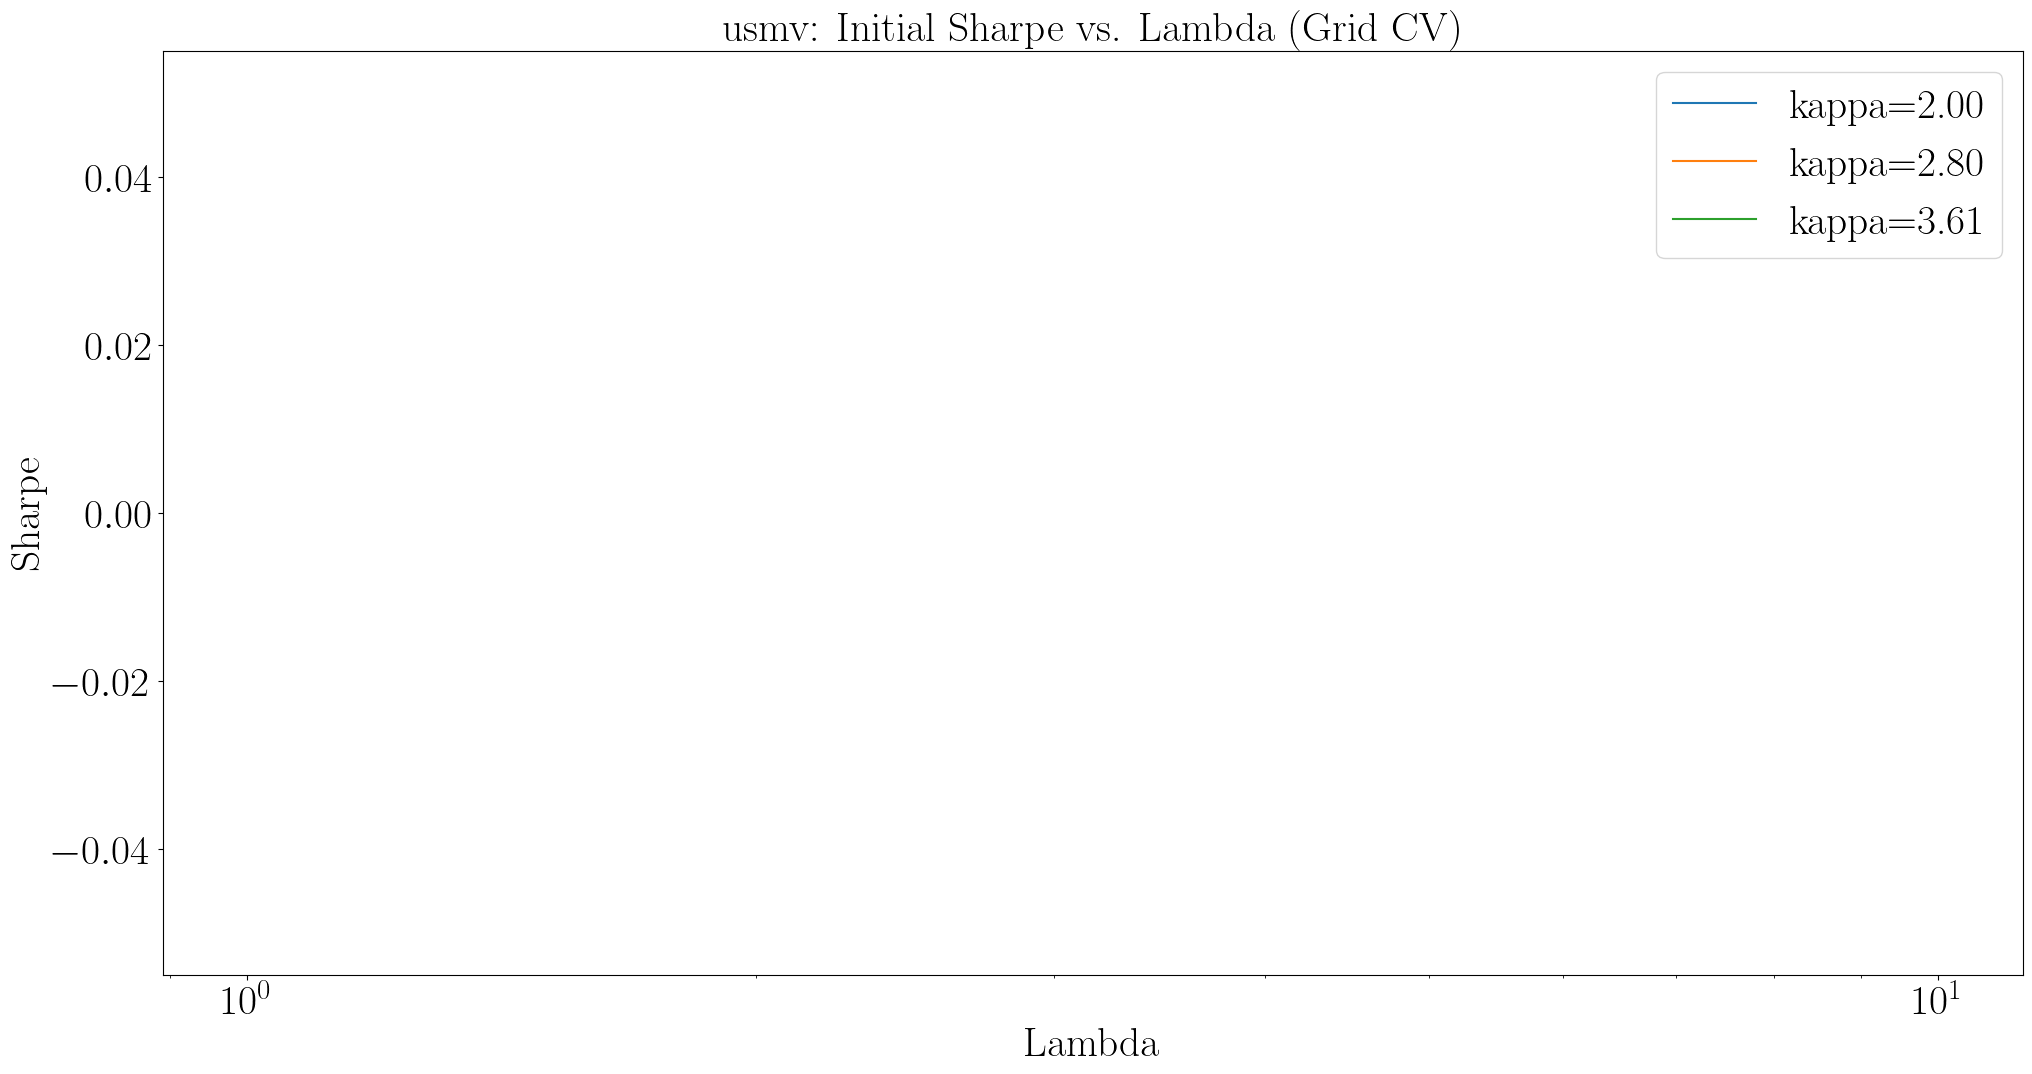


Running initial SJM cross-validation for factor = vlue
Training window: 2009-01-05 00:00:00 to 2016-12-30 00:00:00 (7.98 years)
[vlue] Best Jump Penalty (λ): 30.0
[vlue] Best Max Features (κ²): 4
[vlue] Sharpe with best hyperparams: nan


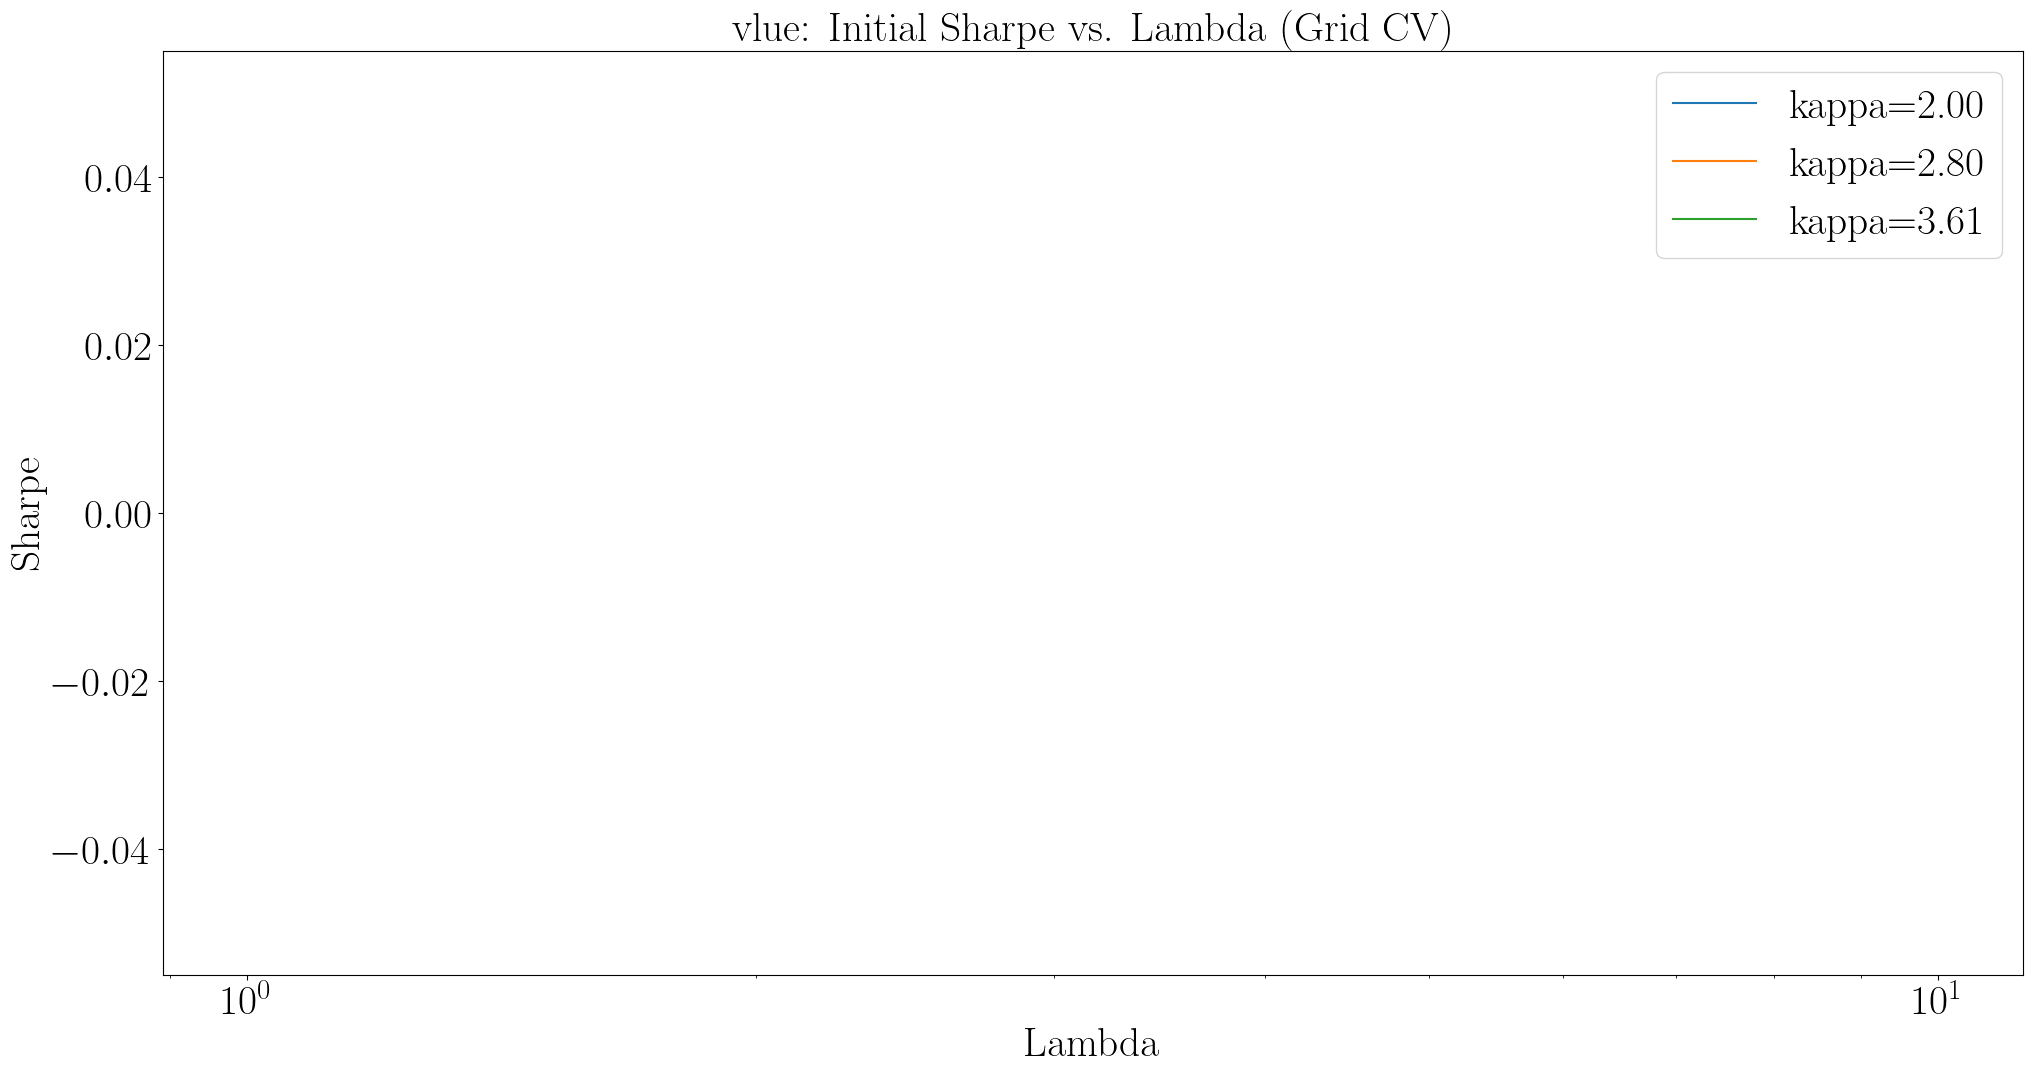


BEGINNING OUT-OF-SAMPLE TRADING WITH ROLLING WINDOW
MIN: 8 years, MAX: 12 years

Trading for period: 2017-01-31 00:00:00 to 2017-02-28 00:00:00
Number of trading days: 19


KeyboardInterrupt: 

In [22]:
if __name__ == "__main__":
    ############################################################################
    # 0) Set parameters
    ############################################################################
    # We define how often to re-fit and re-cross-validate:
    REFIT_FREQ = "ME"  # Monthly refit (can be "QE" or "YE" as desired)
    RECROSS_VAL_FREQ = "YE"  # Yearly re-cross-validation
    
    # Training window configuration
    WINDOW_TYPE = "rolling"  # Options: "expanding" or "rolling"
    MIN_TRAINING_YEARS = 8  # Minimum 8 years of training data
    MAX_TRAINING_YEARS = 12  # Maximum 12 years of training data
    
    # Paths & Tickers
    directory = r"C:\Users\victo\git_new\thesis_vri_vp\data"
    factor_file = os.path.join(directory, "1estimation_index_returns.csv")
    market_file = os.path.join(directory, "1macro_data.csv")
    factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]

    # Date boundaries
    train_start = "2002-05-31"
    test_start = "2017-01-01"

    # Cross-validation settings
    lambda_values = np.linspace(30, 400, 10)  # For grid search
    
    ############################################################################
    # 1) Load full data for all factors & market
    ############################################################################
    # We'll store each factor's entire X and returns in a dict for easy access
    factor_data_dict = {}
    factor_returns_list = []
    for fac in factors:
        print(f"\nLoading data for factor {fac}")
        data = MergedDataLoader(
            factor_file=factor_file,
            market_file=market_file,
            ver="v2",
            factor_col=fac
        ).load()
        common_idx = (
            data.X.index
            .intersection(data.ret_ser.index)
            .intersection(data.market_ser.index)
        )

        # Full factor data
        X_full = data.X.loc[common_idx]
        fac_ret_full = data.ret_ser.loc[common_idx]
        mkt_ret_full = data.market_ser.loc[common_idx]
        active_ret = fac_ret_full - mkt_ret_full

        factor_data_dict[fac] = {
            "X": X_full,
            "fac_ret": fac_ret_full,
            "mkt_ret": mkt_ret_full,
            "active_ret": active_ret
        }
        factor_returns_list.append(fac_ret_full)

    # We'll store the last loaded "mkt_ret_full" as "all_market_ret"
    all_market_ret = mkt_ret_full

    # Combine factor returns + market into a single DF
    full_factors_df = pd.concat(factor_returns_list, axis=1).dropna()  # T x 6
    full_df = pd.concat([full_factors_df, all_market_ret], axis=1).dropna()
    full_df.columns = factors + ["Market"]

    # Our "test_index" is from test_start onward
    test_slice = filter_date_range(full_df, start_date=test_start)
    test_index = test_slice.index.sort_values()

    # Identify refit and re-cross-validation boundaries
    refit_boundaries = (
        test_index.to_series()
        .resample(REFIT_FREQ)
        .last()
        .dropna()
    )
    
    recross_val_boundaries = (
        test_index.to_series()
        .resample(RECROSS_VAL_FREQ)
        .last()
        .dropna()
    )

    ############################################################################
    # 2) Initial Cross-Validation and Hyperparameter Selection
    ############################################################################
    best_hyperparams = {}
    
    print("\n==============================================================")
    print("INITIAL CROSS-VALIDATION (BEFORE TEST PERIOD)")
    print("==============================================================")
    
    # Helper function to get appropriate training window given constraints
    def get_training_window(current_date, full_data, min_years=MIN_TRAINING_YEARS, max_years=MAX_TRAINING_YEARS, 
                           window_type=WINDOW_TYPE, train_start_date=train_start):
        """
        Get training data window based on configuration.
        
        Args:
            current_date: The current date (end of training window)
            full_data: The full dataset (DataFrame with DatetimeIndex)
            min_years: Minimum training window size in years
            max_years: Maximum training window size in years
            window_type: 'expanding' or 'rolling'
            train_start_date: The earliest possible start date
            
        Returns:
            start_date, end_date: The appropriate training window boundaries
        """
        # End date is always the current_date
        end_date = current_date
        
        # Convert date strings to datetime if needed
        if isinstance(train_start_date, str):
            train_start_date = pd.to_datetime(train_start_date)
        if isinstance(current_date, str):
            current_date = pd.to_datetime(current_date)
            
        # For expanding window: use all data from train_start to current_date, 
        # but respect max_years constraint
        if window_type == "expanding":
            # Calculate minimum start date based on max_years
            min_start_date = current_date - pd.DateOffset(years=max_years)
            # Use the later of train_start_date or min_start_date
            start_date = max(train_start_date, min_start_date)
            
        # For rolling window: use exactly min_years of data, or more if min_years
        # would put us before train_start_date
        elif window_type == "rolling":
            # Calculate desired start date based on min_years
            desired_start = current_date - pd.DateOffset(years=min_years)
            # Use the later of train_start_date or desired_start
            start_date = max(train_start_date, desired_start)
            
        else:
            raise ValueError(f"Unknown window_type: {window_type}")
            
        # Filter data to get the actual window
        full_index = full_data.index
        available_dates = full_index[
            (full_index >= start_date) & 
            (full_index <= end_date)
        ]
        
        if len(available_dates) == 0:
            raise ValueError(f"No data available in the requested window: {start_date} to {end_date}")
            
        # Return the actual start and end dates from available data
        return available_dates[0], available_dates[-1]
    
    for factor_name in factors:
        print("\n==============================================================")
        print(f"Running initial SJM cross-validation for factor = {factor_name}")
        print("==============================================================")
        
        # Get data for this factor
        data = factor_data_dict[factor_name]
        X = data["X"]
        
        # Get initial training window based on configuration
        train_start_date, train_end_date = get_training_window(
            pd.to_datetime(test_start), X, 
            min_years=MIN_TRAINING_YEARS, 
            max_years=MAX_TRAINING_YEARS,
            window_type=WINDOW_TYPE,
            train_start_date=train_start
        )
        
        # Filter to initial train period
        X_train = filter_date_range(X, start_date=train_start_date, end_date=train_end_date)
        
        print(f"Training window: {train_start_date} to {train_end_date} ({(train_end_date - train_start_date).days / 365.25:.2f} years)")
        
        # Define kappa values based on number of features
        kappa_values = np.linspace(2, np.sqrt(X_train.shape[1]), 3)
        
        # Run cross-validation in parallel
        results = Parallel(n_jobs=4)(
            delayed(rolling_time_series_cv_sjm_long_short)(
                lam, kappa, 
                X_train,
                factor_returns=data["fac_ret"].loc[X_train.index],
                market_returns=data["mkt_ret"].loc[X_train.index]
            )
            for lam in lambda_values
            for kappa in kappa_values
        )

        # Process results
        results_array = np.array(results).reshape(len(lambda_values), len(kappa_values))
        best_index = np.argmax(results)
        best_lambda = lambda_values[best_index // len(kappa_values)]
        best_kappa = kappa_values[best_index % len(kappa_values)]
        max_feats_best = int(best_kappa**2)
        best_sharpe = results[best_index]

        print(f"[{factor_name}] Best Jump Penalty (λ): {best_lambda}")
        print(f"[{factor_name}] Best Max Features (κ²): {max_feats_best}")
        print(f"[{factor_name}] Sharpe with best hyperparams: {best_sharpe}")

        # Store best hyperparameters
        best_hyperparams[factor_name] = {
            "best_lambda": best_lambda,
            "best_kappa": best_kappa
        }

        # Plot Sharpe vs. Lambda for each kappa (optional)
        plt.figure()
        for i, kp in enumerate(kappa_values):
            plt.plot(lambda_values, results_array[:, i], label=f"kappa={kp:.2f}")
        plt.xscale('log')
        plt.xlabel('Lambda')
        plt.ylabel('Sharpe')
        plt.title(f"{factor_name}: Initial Sharpe vs. Lambda (Grid CV)")
        plt.legend()
        plt.show()

    ############################################################################
    # 3) Loop over re-fit intervals with periodic re-cross-validation
    ############################################################################
    # For tracking performance and decisions
    all_daily_states = {fac: pd.Series(dtype=float) for fac in factors}
    all_daily_weights = []
    all_daily_rets = []
    hyperparameter_history = {fac: [] for fac in factors}  # Track parameter changes
    training_window_history = []  # Track training window sizes
    
    # Keep track of the last re-cross-validation date
    last_recross_val_date = None

    print("\n==============================================================")
    print(f"BEGINNING OUT-OF-SAMPLE TRADING WITH {WINDOW_TYPE.upper()} WINDOW")
    print(f"MIN: {MIN_TRAINING_YEARS} years, MAX: {MAX_TRAINING_YEARS} years")
    print("==============================================================")

    for i in range(len(refit_boundaries) - 1):
        refit_date = refit_boundaries.iloc[i]
        next_refit_date = refit_boundaries.iloc[i + 1]
        
        # Check if we need to re-cross-validate at this refit point
        recross_val_needed = False
        if refit_date in recross_val_boundaries.values:
            # Check if this is a new re-cross-validation period
            if last_recross_val_date is None or refit_date > last_recross_val_date:
                recross_val_needed = True
                last_recross_val_date = refit_date
                print(f"\n{'='*80}")
                print(f"RE-CROSS-VALIDATION AT DATE: {refit_date}")
                print(f"{'='*80}")
                
        # Re-cross-validate if needed to update hyperparameters
        if recross_val_needed:
            for factor_name in factors:
                print(f"\nRe-cross-validation for factor {factor_name}")
                
                # Get data for this factor
                data = factor_data_dict[factor_name]
                X = data["X"]
                factor_returns = data["fac_ret"]
                market_returns = data["mkt_ret"]
                
                # Get appropriate training window based on configuration
                train_start_date, train_end_date = get_training_window(
                    refit_date, X, 
                    min_years=MIN_TRAINING_YEARS, 
                    max_years=MAX_TRAINING_YEARS,
                    window_type=WINDOW_TYPE,
                    train_start_date=train_start
                )
                
                # Use data from train_start_date to refit_date for cross-validation
                X_cv = filter_date_range(X, start_date=train_start_date, end_date=train_end_date)
                
                training_years = (train_end_date - train_start_date).days / 365.25
                print(f"Training window: {train_start_date} to {train_end_date} ({training_years:.2f} years)")
                
                # Track training window
                training_window_history.append({
                    "date": refit_date,
                    "start_date": train_start_date,
                    "end_date": train_end_date,
                    "years": training_years,
                    "window_type": WINDOW_TYPE
                })
                
                # Update kappa values based on current feature count
                kappa_values = np.linspace(2, np.sqrt(X_cv.shape[1]), 3)
                
                # Run cross-validation in parallel
                results = Parallel(n_jobs=4)(
                    delayed(rolling_time_series_cv_sjm_long_short)(
                        lam, kappa, 
                        X_cv,
                        factor_returns=factor_returns.loc[X_cv.index],
                        market_returns=market_returns.loc[X_cv.index]
                    )
                    for lam in lambda_values
                    for kappa in kappa_values
                )

                # Process results
                results_array = np.array(results).reshape(len(lambda_values), len(kappa_values))
                best_index = np.argmax(results)
                best_lambda = lambda_values[best_index // len(kappa_values)]
                best_kappa = kappa_values[best_index % len(kappa_values)]
                max_feats_best = int(best_kappa**2)
                best_sharpe = results[best_index]

                # Store previous hyperparameters for comparison
                old_lambda = best_hyperparams[factor_name]["best_lambda"]
                old_kappa = best_hyperparams[factor_name]["best_kappa"]
                
                print(f"[{factor_name}] Previous λ: {old_lambda}, New λ: {best_lambda}")
                print(f"[{factor_name}] Previous κ²: {int(old_kappa**2)}, New κ²: {max_feats_best}")
                print(f"[{factor_name}] New best Sharpe: {best_sharpe}")
                
                # Track parameter history
                hyperparameter_history[factor_name].append({
                    "date": refit_date,
                    "old_lambda": old_lambda,
                    "new_lambda": best_lambda,
                    "old_kappa": old_kappa,
                    "new_kappa": best_kappa,
                    "sharpe": best_sharpe
                })
                
                # Update best hyperparameters
                best_hyperparams[factor_name] = {
                    "best_lambda": best_lambda,
                    "best_kappa": best_kappa
                }
                
                # Plot Sharpe vs. Lambda if desired (can be commented out)
                plt.figure()
                for i, kp in enumerate(kappa_values):
                    plt.plot(lambda_values, results_array[:, i], label=f"kappa={kp:.2f}")
                plt.xscale('log')
                plt.xlabel('Lambda')
                plt.ylabel('Sharpe')
                plt.title(f"{factor_name} at {refit_date}: Sharpe vs. Lambda")
                plt.legend()
                plt.show()

        # Define the "test chunk" period
        test_mask = (test_index > refit_date) & (test_index <= next_refit_date)
        test_dates_chunk = test_index[test_mask]
        if len(test_dates_chunk) == 0:
            # No trading days in this chunk? Move on
            continue

        print(f"\nTrading for period: {refit_date} to {next_refit_date}")
        print(f"Number of trading days: {len(test_dates_chunk)}")
        
        # Build factor_dict for this chunk
        factor_dict_chunk = {}

        for fac in factors:
            fac_info = factor_data_dict[fac]
            X = fac_info["X"]
            ret_full = fac_info["fac_ret"]
            mkt_full = fac_info["mkt_ret"]
            active = fac_info["active_ret"]

            # -----------------------------------------------------------------
            # 3A) Build training data with appropriate window
            # -----------------------------------------------------------------
            # Get appropriate training window based on configuration
            train_start_date, train_end_date = get_training_window(
                refit_date, X, 
                min_years=MIN_TRAINING_YEARS, 
                max_years=MAX_TRAINING_YEARS,
                window_type=WINDOW_TYPE,
                train_start_date=train_start
            )
            
            X_train = filter_date_range(X, start_date=train_start_date, end_date=train_end_date)
            y_train = filter_date_range(active, start_date=train_start_date, end_date=train_end_date)

            # Scale + Clip the training set
            clipper = DataClipperStd(mul=3.0)
            scaler_pd = StandardScalerPD()
            X_train_clip = clipper.fit_transform(X_train)
            X_train_proc = scaler_pd.fit_transform(X_train_clip)

            # Fit SJM with best hyperparams (which may have been updated in re-CV)
            lam = best_hyperparams[fac]["best_lambda"]
            kp = best_hyperparams[fac]["best_kappa"]
            max_feats = int(kp**2)

            sjm = SparseJumpModel(n_components=2, max_feats=max_feats, jump_penalty=lam)
            sjm.fit(X_train_proc, ret_ser=y_train, sort_by="cumret")

            # -----------------------------------------------------------------
            # 3B) Daily "online" inference from refit_date+1 to next_refit_date
            # -----------------------------------------------------------------
            # For each day in test_dates_chunk, do day-by-day scaling and inference
            X_test_proc_list = []
            for day in test_dates_chunk:
                # Build incremental history from [train_start : day]
                # For online scaling, we use all available history up to the current day
                X_hist = X.loc[:day]

                # Clip & scale X_hist
                ctemp = DataClipperStd(mul=3.0)
                X_hist_clip = ctemp.fit_transform(X_hist)

                stemp = StandardScaler()
                X_hist_scal = stemp.fit_transform(X_hist_clip)

                # Transform just the row for 'day'
                if day in X.index:
                    X_day = X.loc[[day]]
                    X_day_clip = ctemp.transform(X_day)
                    X_day_scal = stemp.transform(X_day_clip)
                    X_test_proc_list.append(
                        pd.Series(X_day_scal.flatten(), index=X_day.columns, name=day)
                    )

            X_test_proc_df = pd.DataFrame(X_test_proc_list).sort_index()

            # Predict states
            if not X_test_proc_df.empty:
                states_chunk = sjm.predict_online(X_test_proc_df)
                states_series = pd.Series(states_chunk, index=X_test_proc_df.index)
            else:
                states_series = pd.Series(dtype=float)

            # Accumulate to the "global" daily states for that factor
            series_to_concat = [s for s in [all_daily_states[fac], states_series] if not s.empty]
            if series_to_concat:
                all_daily_states[fac] = pd.concat(series_to_concat).sort_index()
            else:
                all_daily_states[fac] = pd.Series(dtype=float)

            # Store factor info needed for BL
            factor_dict_chunk[fac] = {
                "ret": ret_full,  # full factor ret
                "states": states_series,
                "regime_returns": {
                    0: sjm.ret_[0],
                    1: sjm.ret_[1],
                },
            }

        # ---------------------------------------------------------------------
        # 3C) Run BL daily over test_dates_chunk
        # ---------------------------------------------------------------------
        weights_chunk = run_bl_portfolio_pyopt_expanding(
            factor_dict=factor_dict_chunk,
            returns_df=full_df,
            test_index=test_dates_chunk,
            tau=0.05,
            delta=2.5
        )

        # ---------------------------------------------------------------------
        # 3D) Compute daily returns for test_dates_chunk
        # ---------------------------------------------------------------------
        daily_factor_rets = full_df.loc[test_dates_chunk, factors]
        portfolio_rets = (weights_chunk * daily_factor_rets).sum(axis=1)

        # Store results
        all_daily_weights.append(weights_chunk)
        all_daily_rets.append(portfolio_rets)

    ############################################################################
    # 4) Analyze Results and Compare to Benchmarks
    ############################################################################
    if len(all_daily_rets) == 0:
        raise ValueError("No daily returns computed. Check your date ranges or data.")

    all_portfolio_rets = pd.concat(all_daily_rets).sort_index()
    all_weights_df = pd.concat(all_daily_weights).sort_index()
    cumrets = all_portfolio_rets.cumsum()

    # Compare to equal-weight benchmark
    overlap_idx = all_portfolio_rets.index.intersection(full_df.index)
    test_returns_df = full_df.loc[overlap_idx, :]
    ew_bench_rets = test_returns_df.mean(axis=1)
    ew_bench_cum = ew_bench_rets.cumsum()
    
    # Also compute quarterly-rebalanced EW portfolio (as in your code)
    quarterly_ends = test_returns_df.index.to_series().resample("QE").last().dropna()
    n_assets = test_returns_df.shape[1]
    quarterly_ew_rets = pd.Series(index=test_returns_df.index, dtype=float)

    for i in range(len(quarterly_ends) - 1):
        start_q = quarterly_ends.iloc[i]
        end_q = quarterly_ends.iloc[i + 1]
        mask = (test_returns_df.index > start_q) & (test_returns_df.index <= end_q)
        chunk_dates = test_returns_df.index[mask]
        
        w = np.ones(n_assets) / n_assets
        
        for day in chunk_dates:
            r_i = test_returns_df.loc[day].values
            r_p = np.dot(w, r_i)
            quarterly_ew_rets.loc[day] = r_p
            
            w = w * (1 + r_i)
            if (1 + r_p) != 0:
                w /= (1 + r_p)

    quarterly_ew_rets = quarterly_ew_rets.dropna()
    quarterly_ew_cum = quarterly_ew_rets.cumsum()

    ############################################################################
    # 5) Plot Results and Print Performance Statistics
    ############################################################################
    # Plot 1: Cumulative returns comparison
    plt.figure(figsize=(12, 6))
    cumrets.plot(label=f"Dynamic BL with {WINDOW_TYPE.capitalize()} Window ({MIN_TRAINING_YEARS}-{MAX_TRAINING_YEARS} yrs)")
    ew_bench_cum.plot(label="Daily EW Benchmark", linestyle="--")
    quarterly_ew_cum.plot(label="Quarterly EW Benchmark", linestyle="-.")
    
    # Add vertical lines at re-cross-validation dates
    for date in recross_val_boundaries:
        if date in cumrets.index:
            plt.axvline(x=date, color='r', linestyle='--', alpha=0.3, 
                        label="Re-Cross-Validation" if date == recross_val_boundaries[0] else "")
    
    plt.title("Cumulative Returns Comparison (Test Period)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Factor weights over time
    plt.figure(figsize=(12, 6))
    all_weights_df.plot()
    plt.title("Factor Weights Over Time")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(True)
    plt.show()

    # Plot 3: Training window size over time (new plot to visualize window size)
    if training_window_history:
        tw_df = pd.DataFrame(training_window_history)
        tw_df.set_index('date', inplace=True)
        
        plt.figure(figsize=(12, 6))
        plt.plot(tw_df.index, tw_df['years'])
        plt.title(f"Training Window Size Over Time ({WINDOW_TYPE} Window)")
        plt.ylabel("Window Size (Years)")
        plt.grid(True)
        plt.show()

    # Plot 4: Regime visualization for each factor (optional)
    for factor_name in factors:
        if not all_daily_states[factor_name].empty:
            states_df = all_daily_states[factor_name]
            active_ret = factor_data_dict[factor_name]["active_ret"]
            common_idx = states_df.index.intersection(active_ret.index)
            
            if len(common_idx) > 0:
                ax, ax2 = plot_regimes_and_cumret(
                    states_df.loc[common_idx], 
                    active_ret.loc[common_idx]
                )
                ax.set_title(f"{factor_name} - Test Period Regimes")
                plt.show()

    # Print performance statistics
    print("\n==============================================================")
    print("PERFORMANCE SUMMARY")
    print("==============================================================")
    print(f"Strategy: Dynamic BL with {WINDOW_TYPE.capitalize()} Window ({MIN_TRAINING_YEARS}-{MAX_TRAINING_YEARS} yrs)")
    print(f"Period: {all_portfolio_rets.index[0]} to {all_portfolio_rets.index[-1]}")
    print(f"Number of trading days: {len(all_portfolio_rets)}")
    print("\nAnnualized Performance Metrics:")
    print(f"Daily EW Benchmark Sharpe: {annualized_sharpe(ew_bench_rets):.4f}")
    print(f"Quarterly EW Benchmark Sharpe: {annualized_sharpe(quarterly_ew_rets):.4f}")
    print(f"Dynamic BL Portfolio Sharpe: {annualized_sharpe(all_portfolio_rets):.4f}")
    print(f"\nTotal Returns:")
    print(f"Daily EW Benchmark Return: {ew_bench_cum.iloc[-1]:.4f}")
    print(f"Quarterly EW Benchmark Return: {quarterly_ew_cum.iloc[-1]:.4f}")
    print(f"Dynamic BL Portfolio Return: {cumrets.iloc[-1]:.4f}")
    
    # Print hyperparameter evolution
    print("\n==============================================================")
    print("HYPERPARAMETER EVOLUTION")
    print("==============================================================")
    for fac in factors:
        if hyperparameter_history[fac]:
            print(f"\nFactor: {fac}")
            for entry in hyperparameter_history[fac]:
                print(f"Date: {entry['date']}")
                print(f"  Lambda: {entry['old_lambda']:.2f} -> {entry['new_lambda']:.2f}")
                print(f"  Kappa²: {int(entry['old_kappa']**2)} -> {int(entry['new_kappa']**2)}")
                print(f"  Sharpe: {entry['sharpe']:.4f}")
        else:
            print(f"\nFactor: {fac} - No parameter changes")

    # Print training window evolution
    if training_window_history:
        print("\n==============================================================")
        print(f"TRAINING WINDOW EVOLUTION ({WINDOW_TYPE.upper()})")
        print("==============================================================")
        for entry in training_window_history:
            print(f"Date: {entry['date']}")
            print(f"  Window: {entry['start_date']} to {entry['end_date']}")
            print(f"  Size: {entry['years']:.2f} years")